# Parse Experimental Results & Generate Latex Table

In [1]:
% matplotlib inline
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = 'data/data-recsys16'

In [3]:
suffix = ['Osak', 'Glas', 'Edin', 'Toro', 'Melb']
datnames = ['Osaka', 'Glasgow', 'Edinburgh', 'Toronto', 'Melbourne']

In [4]:
datasettypes = ['all', 'noshort', 'nofew']

In [5]:
methods = ['RankP', 'RankF', 'MC-DP', 'MC-ILP', 'Prop-DP', 'Prop-ILP']

Compute the F1 score for recommended trajectory.

In [6]:
def calc_F1(seq_act, seq_rec):
    '''Compute recall, precision and F1 when trajectories contain sub-tours'''
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)
    match_tags = np.zeros(len(seq_act), dtype=np.bool)
    for poi in seq_rec:
        for j in range(len(seq_act)):
            if match_tags[j] == False and poi == seq_act[j]:
                match_tags[j] = True
                break
    intersize = np.nonzero(match_tags)[0].shape[0]
    recall = intersize / len(seq_act)
    precision = intersize / len(seq_rec)
    F1 = 2 * precision * recall / (precision + recall)
    return F1

Load results data.

In [7]:
def load_results(dstype, dat_ix, kxstr, alphastr, uspecific=False):
    assert(dstype in datasettypes)
    assert(0 <= dat_ix <= len(suffix))
    
    if uspecific == True:
        # user specific results
        frecdict_rank = os.path.join(data_dir, 'rank-' + dstype + '-specific-' + kxstr + suffix[dat_ix] + '.pkl')
        frecdict_tran = os.path.join(data_dir, 'tran-' + dstype + '-specific-' + kxstr + suffix[dat_ix] + '.pkl')
        frecdict_comb = os.path.join(data_dir, 'comb-' + dstype + '-specific-'+alphastr+kxstr+suffix[dat_ix]+'.pkl')
    else:
        # user agnostic results
        frecdict_rank = os.path.join(data_dir, 'rank-' + dstype + '-agnostic-' + suffix[dat_ix] + '.pkl')
        frecdict_tran = os.path.join(data_dir, 'tran-' + dstype + '-agnostic-' + suffix[dat_ix] + '.pkl')
        frecdict_comb = os.path.join(data_dir, 'comb-' + dstype + '-agnostic-' + alphastr + suffix[dat_ix] + '.pkl')

    # load results data
    recdict_rank = pickle.load(open(frecdict_rank, 'rb'))
    recdict_tran = pickle.load(open(frecdict_tran, 'rb'))
    recdict_comb = pickle.load(open(frecdict_comb, 'rb'))
    
    return recdict_rank, recdict_tran, recdict_comb

Calculate F1-scores from loaded results.

In [8]:
def calc_metrics(recdict_rank, recdict_tran, recdict_comb):
    # compute F1
    F1_rank1 = []  # rank pop
    F1_rank2 = []  # rank feature
    for key in sorted(recdict_rank.keys()):
        F1_rank1.append(calc_F1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_POP']))
        F1_rank2.append(calc_F1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_FEATURE']))
    
    F1_tran1 = []  # transition DP
    F1_tran2 = []  # transition ILP
    for key in sorted(recdict_tran.keys()):
        F1_tran1.append(calc_F1(recdict_tran[key]['REAL'], recdict_tran[key]['REC_DP']))
        F1_tran2.append(calc_F1(recdict_tran[key]['REAL'], recdict_tran[key]['REC_ILP']))

    F1_comb1 = []  # combine rank and transition DP
    F1_comb2 = []  # combine rank and transition ILP
    for key in sorted(recdict_comb.keys()):
        F1_comb1.append(calc_F1(recdict_comb[key]['REAL'], recdict_comb[key]['REC_DP']))
        F1_comb2.append(calc_F1(recdict_comb[key]['REAL'], recdict_comb[key]['REC_ILP']))
    
    # compute mean and std of F1
    F1_mean = [np.mean(x) for x in [F1_rank1, F1_rank2, F1_tran1, F1_tran2, F1_comb1, F1_comb2]]
    F1_std  = [np.std(x)  for x in [F1_rank1, F1_rank2, F1_tran1, F1_tran2, F1_comb1, F1_comb2]]
    
    return F1_mean, F1_std

Generate Latex tables from calculated metrics.

In [9]:
def gen_latex_table(F1mean_df, F1std_df, ismax_df, dstype, uspecific):
    assert(isinstance(uspecific, bool))
    ustr = 'user specific setting' if uspecific else 'user agnostic setting'
    if dstype == 'all': dstr = 'with all trajectories'
    if dstype == 'noshort': dstr = 'without short trajectories'
    if dstype == 'nofew': dstr = 'without users with less than 5 trajectories'

    strs = []
    strs.append('\\begin{table*}\n')
    strs.append('\\centering\n')
    strs.append('\\caption{Experimental Results: ' + ustr + ' ' + dstr + '}\n')
    #strs.append('\\small\n')
    strs.append('\\begin{tabular}{l|' + (F1mean_df.shape[1])*'c' + '} \\hline\n')
    for col in F1mean_df.columns:
        strs.append(' & ' + col)
    strs.append(' \\\\ \\hline\n')
    for ix in F1mean_df.index:
        for j in range(F1mean_df.shape[1]):
            if j == 0: strs.append(ix + ' ')
            jx = F1mean_df.columns[j]
            strs.append('& $')
            if ismax_df.loc[ix, jx] == True: strs.append('\\mathbf{')
            strs.append('%.3f' % F1mean_df.loc[ix, jx] + '\\pm' + '%.3f' % F1std_df.loc[ix, jx])
            if ismax_df.loc[ix, jx] == True: strs.append('}')
            strs.append('$ ')
        strs.append('\\\\\n')
    strs.append('\\hline\n')
    strs.append('\\end{tabular}\n')
    strs.append('\\end{table*}\n')
    return ''.join(strs)

In [10]:
KX = 100  # 100 folds in user specific setting
kxstr = str(KX) + 'X-'
ALPHA = 0.5
alphastr = str(ALPHA).replace('.', '_') + '-'

In [ ]:
for dstype in datasettypes:
    F1mean_agno_df = pd.DataFrame(data=np.zeros((len(methods), len(datnames)), dtype=np.float), \
                                  columns=datnames, index=methods)
    F1std_agno_df  = pd.DataFrame(data=np.zeros((len(methods), len(datnames)), dtype=np.float), \
                                  columns=datnames, index=methods)
    F1mean_spec_df = pd.DataFrame(data=np.zeros((len(methods), len(datnames)), dtype=np.float), \
                                  columns=datnames, index=methods)
    F1std_spec_df  = pd.DataFrame(data=np.zeros((len(methods), len(datnames)), dtype=np.float), \
                                  columns=datnames, index=methods) 
    
    for dat_ix in range(len(suffix)):
        recdict_rank1, recdict_tran1, recdict_comb1 = load_results(dstype, dat_ix, kxstr, alphastr, uspecific=False)
        F1mean_agno, F1std_agno = calc_metrics(recdict_rank1, recdict_tran1, recdict_comb1)
        
        recdict_rank2, recdict_tran2, recdict_comb2 = load_results(dstype, dat_ix, kxstr, alphastr, uspecific=True)
        F1mean_spec, F1std_spec = calc_metrics(recdict_rank2, recdict_tran2, recdict_comb2)
        
        assert(len(F1mean_agno) == len(F1std_agno) == len(methods))
        assert(len(F1mean_spec) == len(F1std_spec) == len(methods))
        F1mean_agno_df[datnames[dat_ix]] = F1mean_agno
        F1mean_spec_df[datnames[dat_ix]] = F1mean_spec
        F1std_agno_df[datnames[dat_ix]] = F1std_agno
        F1std_spec_df[datnames[dat_ix]] = F1std_spec  
    
    ismax_agno_df  = pd.DataFrame(data=np.zeros(F1mean_agno_df.shape, dtype=np.bool), \
                                  columns=F1mean_agno_df.columns, index=F1mean_agno_df.index)
    ismax_spec_df  = pd.DataFrame(data=np.zeros(F1mean_spec_df.shape, dtype=np.bool), \
                                  columns=F1mean_spec_df.columns, index=F1mean_spec_df.index)
    for col in ismax_agno_df.columns:
        maxix = F1mean_agno_df[col].argmax()
        ismax_agno_df.loc[maxix, col] = True
    for col in ismax_spec_df.columns:
        maxix = F1mean_spec_df[col].argmax()
        ismax_spec_df.loc[maxix, col] = True
        
    str_agno = gen_latex_table(F1mean_agno_df, F1std_agno_df, ismax_agno_df, dstype, uspecific=False)
    str_spec = gen_latex_table(F1mean_spec_df, F1std_spec_df, ismax_spec_df, dstype, uspecific=True)
    
    print(str_agno)
    print(str_spec)

Generate Latex table for dataset statistics.

In [12]:
#nPhotos = {'Edin': 82060, 'Glas': 29019, 'Osak': 392420, 'Toro':157505, 'Melb':}

In [ ]:
strs = []
for dset in datasettypes:
    if dset == 'all':     title = 'with all trajectories'
    if dset == 'noshort': title = 'without short trajectories'
    if dset == 'nofew':   title = 'without users with less than 5 trajectories'
    strs.append('\\begin{table*}\n')
    strs.append('\\centering\n')
    strs.append('\\caption{Dataset ' + title + '}\n')
    strs.append('\\label{table:data:' + dset + '}\n')
    #strs.append('\\small\n')
    strs.append('\\begin{tabular}{' + 'l' + 5*'r' + '} \\hline\n')
    strs.append('\\textbf{City} & \\textbf{\\#POIs} & \\textbf{\\#Users} & ')
    strs.append('\\textbf{\\#POI Visits} & \\textbf{\\#Trajectories} & \\textbf{\\#TotalNodes} \\\\ \\hline\n')
    
    for dat_ix in range(len(datnames)):
        ftraj = os.path.join(data_dir, 'traj-' + dset + '-' + suffix[dat_ix] + '.csv')
        traj_df = pd.read_csv(ftraj)
        total_nodes = traj_df[['trajID', 'trajLen']].copy().groupby('trajID').first().sum().values[0]
        strs.append(datnames[dat_ix])
        strs.append(' & ' + '{:,}'.format(traj_df['poiID'].unique().shape[0]))
        strs.append(' & ' + '{:,}'.format(traj_df['userID'].unique().shape[0]))
        strs.append(' & ' + '{:,}'.format(traj_df['#photo'].sum()))
        strs.append(' & ' + '{:,}'.format(traj_df['trajID'].unique().shape[0]))
        strs.append(' & ' + '{:,}'.format(total_nodes))
        strs.append(' \\\\ \n')
    strs.append('\\hline\n')
    strs.append('\\end{tabular}\n')
    strs.append('\\end{table*}\n\n')
print(''.join(strs))

Tuning hyperparams.  
NOTE: **POI popularity** used here is defined as *the number of distinct users* that visited the POI, which is not affected by user specific upsampling of trajectories.

In [14]:
dstype = datasettypes[2]
dat_ix = 1

In [15]:
KXs = [1, 2, 4, 8, 10, 20, 50, 100]
ALPHAs = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

Methods based on ranking and transition matrix.

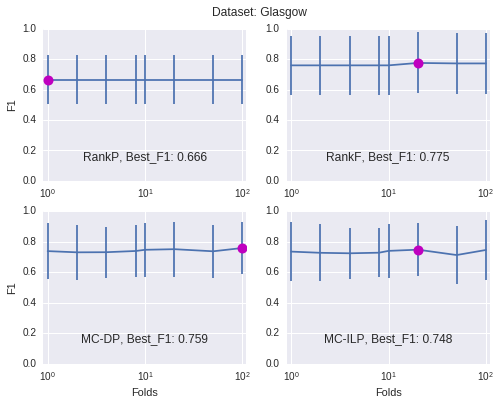

In [16]:
methods_F1mean = np.zeros((4, len(KXs)), dtype=np.float)
methods_F1std = np.zeros((4, len(KXs)), dtype=np.float)
alphastr = str(0.5).replace('.', '_') + '-'
for j in range(len(KXs)):
    kx = KXs[j]
    kxstr = str(kx) + 'X-'
    recdict_rank, recdict_tran, recdict_comb = load_results(dstype, dat_ix, kxstr, alphastr, uspecific=True)
    F1mean, F1std = calc_metrics(recdict_rank, recdict_tran, recdict_comb)
    for method_ix in [0, 1, 2, 3]:
        methods_F1mean[method_ix, j] = F1mean[method_ix]
        methods_F1std[method_ix, j] = F1std[method_ix]

plt.figure(figsize=[8, 6])
plt.suptitle('Dataset: %s' % datnames[dat_ix], y=0.95, fontsize=12)
for k in [0, 1, 2, 3]:
    ax = plt.subplot(2, 2, k+1)
    plt.errorbar(KXs, methods_F1mean[k], yerr=methods_F1std[k])
    maxix = np.argmax(methods_F1mean[k])
    plt.plot(KXs[maxix], methods_F1mean[k, maxix], marker='o', markersize=10, markerfacecolor='m', markeredgewidth=0)
    plt.xlim([0.9, 109])
    plt.ylim([0, 1.0])
    plt.title('%s, Best_F1: %.3f' % (methods[k], methods_F1mean[k, maxix]), y=0.1)
    plt.xscale('log')
    if k > 1: plt.xlabel('Folds')
    if k % 2 == 0: plt.ylabel('F1')

Methods combine ranking with transition matrix.

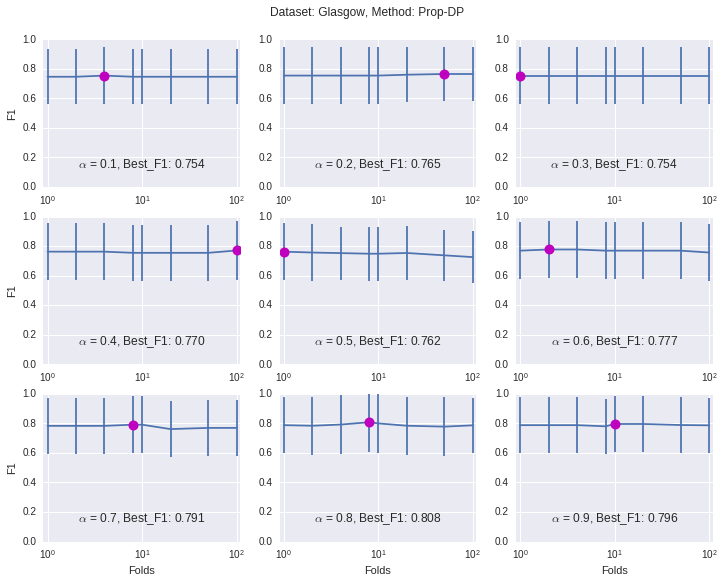

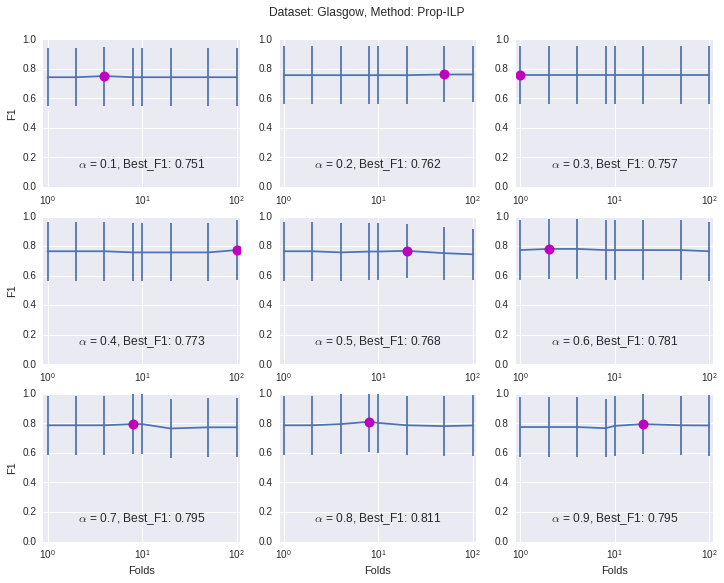

In [17]:
for method_ix in [4, 5]:
    method_F1mean = np.zeros((len(ALPHAs), len(KXs)), dtype=np.float)
    method_F1std = np.zeros((len(ALPHAs), len(KXs)), dtype=np.float)
    for i in range(len(ALPHAs)):
        alpha = ALPHAs[i]
        alphastr = str(alpha).replace('.', '_') + '-'
        for j in range(len(KXs)):
            kx = KXs[j]
            kxstr = str(kx) + 'X-'
            recdict_rank, recdict_tran, recdict_comb = load_results(dstype, dat_ix, kxstr, alphastr, uspecific=True)
            F1mean, F1std = calc_metrics(recdict_rank, recdict_tran, recdict_comb)
            method_F1mean[i, j] = F1mean[method_ix]
            method_F1std[i, j] = F1std[method_ix]

    plt.figure(figsize=[12, 9])
    plt.suptitle('Dataset: %s, Method: %s' % (datnames[dat_ix], methods[method_ix]), y=0.95, fontsize=12)
    for k in range(len(ALPHAs)):
        ax = plt.subplot(3, 3, k+1)
        plt.errorbar(KXs, method_F1mean[k], yerr=method_F1std[k])
        maxix = np.argmax(method_F1mean[k])
        plt.plot(KXs[maxix], method_F1mean[k, maxix], marker='o', markersize=10, markerfacecolor='m', markeredgewidth=0)
        plt.xlim([0.9, 109])
        plt.ylim([0, 1.0])
        plt.title('$\\alpha$ = %.1f, Best_F1: %.3f' % (ALPHAs[k], method_F1mean[k, maxix]), y=0.1)
        plt.xscale('log')
        if k > 5: plt.xlabel('Folds')
        if k % 3 == 0: plt.ylabel('F1')